[View in Colaboratory](https://colab.research.google.com/github/taiki323/kaggle_training/blob/master/Google_Analytics_Customer_Revenue_Prediction.ipynb)

# 課題
- Google Merchandise Storeの顧客データを分析して、顧客あたりの収益を予測する。

- 各fullVisitorIdに対して、PredictedLogRevenueで総収入の自然対数を予測する。RMSEで評価

![target](https://github.com/taiki323/image_house/blob/master/target1.PNG?raw=true)

# セットアップ

In [0]:
!pip install kaggle　
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

In [110]:
import pandas as pd
import numpy as np
import datetime
import re
import sklearn, scipy
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from time import sleep
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# !mkdir .kaggle
!mkdir ~/.kaggle
%cd /content
!mkdir work
%cd work
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c ga-customer-revenue-prediction

/content
/content/work
100% 5.22M/5.22M [00:00<00:00, 52.1MB/s]

 66% 35.0M/53.3M [00:00<00:00, 83.6MB/s]
100% 53.3M/53.3M [00:00<00:00, 174MB/s] 
 85% 49.0M/57.5M [00:00<00:00, 91.6MB/s]
100% 57.5M/57.5M [00:00<00:00, 135MB/s] 


In [10]:
!unzip '*.zip'

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test.csv.zip
  inflating: test.csv                

3 archives were successfully processed.


# 前処理

## データ確認
１回のストア訪問につき、１行のデータになる。

train:90万データ   
test: 80万データ
- fullVisitorId: 一意なユーザID
- channelGrouping: ユーザがストアにアクセスした経路(アフィリエイトなど)
- date: ストアに訪れた日付
- device: ユーザが使用したデバイス
- geoNetwork: ユーザがいる地域
- sessionId: セッションID
- socialEngagementType: Not Socially Engagedしかデータない
- totals: セッション全体の集計値
- trafficSource: トラフィックソースの情報
- visitId: セッションID。ユーザにのみ一意。
- visitNumber: セッション番号。初回アクセスなら1。
- visitStartTime: ストアに訪れた時間

In [0]:
#データ読み込み
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)

    for column in JSON_COLUMNS:
        df = df.join(pd.DataFrame(df.pop(column).apply(pd.io.json.loads).values.tolist(), index=df.index))

    return df
  
train = load_df("/content/work/train.csv")
test = load_df("/content/work/test.csv")

In [12]:
print(train.shape)
print(test.shape)
train.head()

(903653, 50)
(804684, 48)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,...,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,True,(not provided),organic,NaN,google


In [13]:
#trainデータにあって、testデータに無いカラム
diff_col = list(set(train.columns) - set(test.columns))
print(diff_col)

['campaignCode', 'transactionRevenue']


## データクレイジング

### 不要なカラムの除去

In [14]:
#全て同じ値のカラムを削除
train['adwordsClickInfo'] = train['adwordsClickInfo'].astype(str)
test['adwordsClickInfo'] = test['adwordsClickInfo'].astype(str)
train['hits'] = train['hits'].astype(int)
test['hits'] = test['hits'].astype(int)
train = train.drop('campaignCode',axis=1)

for column in train.columns:
  if len(train[column].value_counts()) == 1:
    train = train.drop(column,axis=1)
    test = test.drop(column,axis=1)
    print(column)

socialEngagementType
browserSize
browserVersion
flashVersion
language
mobileDeviceBranding
mobileDeviceInfo
mobileDeviceMarketingName
mobileDeviceModel
mobileInputSelector
operatingSystemVersion
screenColors
screenResolution
cityId
latitude
longitude
networkLocation
bounces
newVisits
visits
isTrueDirect


In [15]:
#欠損値を確認
def kesson_table (df):
  null_val = df.isnull().sum()
  percent = (null_val / len(df)) * 100
  kesson_table = pd.concat([null_val, percent],axis=1)
  kesson_table_ren_columns = kesson_table.rename(columns={0:'欠損値', 1:'%'})
  return kesson_table_ren_columns

print(kesson_table(train))
print(kesson_table(test))

                       欠損値          %
channelGrouping          0   0.000000
date                     0   0.000000
fullVisitorId            0   0.000000
sessionId                0   0.000000
visitId                  0   0.000000
visitNumber              0   0.000000
visitStartTime           0   0.000000
browser                  0   0.000000
deviceCategory           0   0.000000
isMobile                 0   0.000000
operatingSystem          0   0.000000
city                     0   0.000000
continent                0   0.000000
country                  0   0.000000
metro                    0   0.000000
networkDomain            0   0.000000
region                   0   0.000000
subContinent             0   0.000000
hits                     0   0.000000
pageviews              100   0.011066
transactionRevenue  892138  98.725728
adContent           892707  98.788694
adwordsClickInfo         0   0.000000
campaign                 0   0.000000
keyword             502929  55.655102
medium      

In [0]:
#半分以上データが欠損しているカラムを削除
#transactionRevenueは目的変数なので削除しない
del_columns = ["referralPath","keyword", "adContent"]
train = train.drop(del_columns, axis=1)
test = test.drop(del_columns, axis=1)

In [0]:
#予測に関係のないデータを削除
unwanted = ["adwordsClickInfo", "sessionId"]
train = train.drop(unwanted, axis=1)
test = test.drop(unwanted, axis=1)

In [0]:
#transactionRevenueのNaNを0埋め
train['transactionRevenue'] = train['transactionRevenue'].fillna(0)

In [19]:
print(train.shape)
print(test.shape)
print(train.columns)

(903653, 23)
(804684, 22)
Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'browser', 'deviceCategory', 'isMobile',
       'operatingSystem', 'city', 'continent', 'country', 'metro',
       'networkDomain', 'region', 'subContinent', 'hits', 'pageviews',
       'transactionRevenue', 'campaign', 'medium', 'source'],
      dtype='object')


## プロット

### transactionRevenueの散布図
お金を払っているユーザの割合


お金を払っているユーザの割合は全体の 1.399672625590373 %


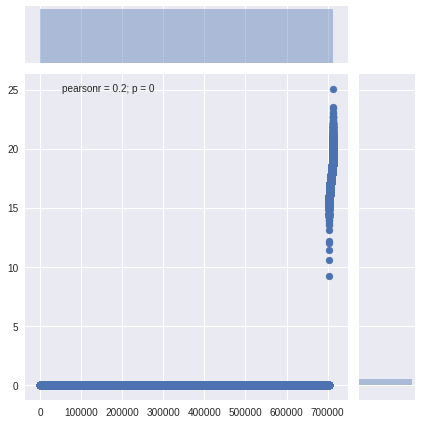

In [20]:
#fullVisitorIdのグループ毎にtransactionRevenueの合計算出
train['transactionRevenue'] = train['transactionRevenue'].astype(int)
gdf = train.groupby('fullVisitorId')['transactionRevenue'].sum().reset_index()
gdf = gdf.sort_values('transactionRevenue')
sns.jointplot(np.arange(gdf.shape[0]),np.log1p(gdf['transactionRevenue'].values))
print("お金を払っているユーザの割合は全体の" ,100 * ((gdf['transactionRevenue']>0).sum()) / gdf.shape[0], "%")

In [0]:
#日付の型をdatetimeに変換
train['date'] = train['date'].apply(lambda x : datetime.date(int(str(x)[0:4]),int(str(x)[4:6]),int(str(x)[6:8])))
test['date'] = test['date'].apply(lambda x : datetime.date(int(str(x)[0:4]),int(str(x)[4:6]),int(str(x)[6:8])))

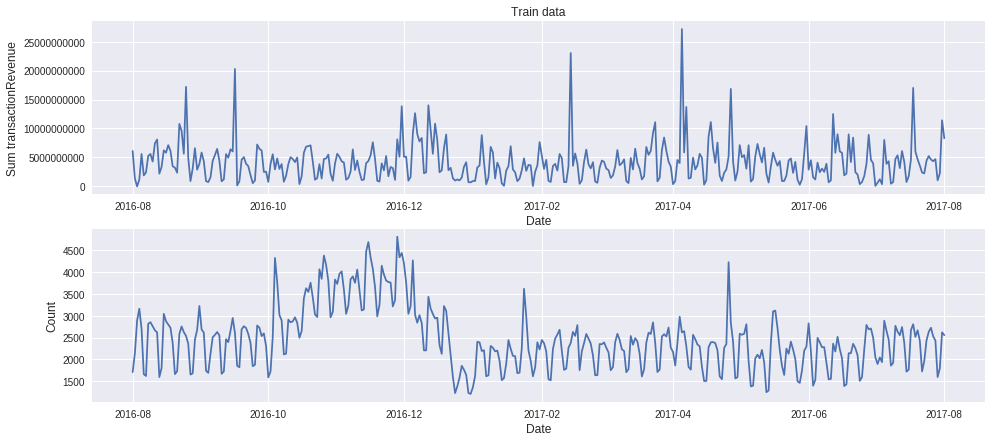

In [22]:
#日付毎の訪問者数と収入をプロット
dateRev = train.groupby('date')['transactionRevenue'].agg(['count', 'sum'])
plt.figure(figsize=(16,7))
plt.subplot(2,1,1)
plt.title('Train data')
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Sum transactionRevenue', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.plot(dateRev.index.values, dateRev['sum'])

plt.subplot(2,1,2)
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.plot(dateRev.index.values, dateRev['count'])

train dataは2016年8月～2017年7月末までのデータ   
2016年10月～2016年12月くらいまで訪問者増加   
しかし、収入はあまり増えていないので、お金を落とさない客が多く来たことが分かる

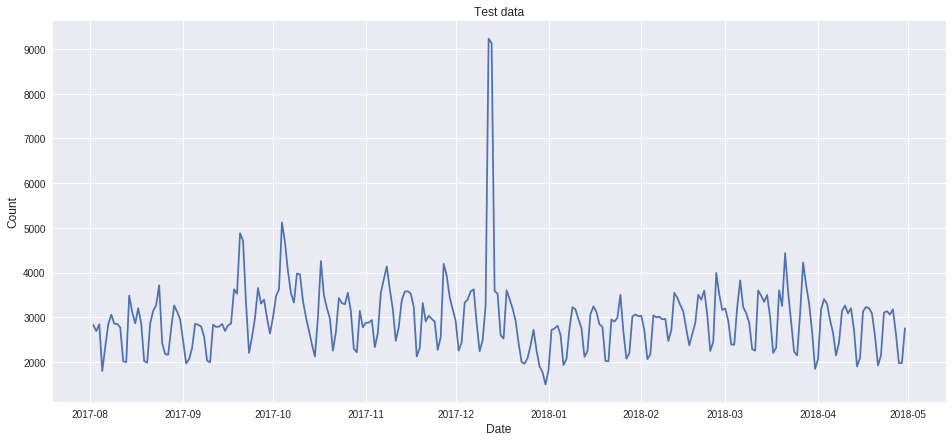

In [23]:
#日付毎の訪問者数と収入をプロット
dateRevtest = test.groupby('date')['fullVisitorId'].agg(['count'])
plt.figure(figsize=(16,7))
plt.title('Test data')
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.plot(dateRevtest.index.values, dateRevtest['count'])

test dataは2017年8月～2018年4月末までのデータ

### 棒グラフ

In [0]:
#新しい列追加　
train['Revenue'] = None
train['Revenue'][train['transactionRevenue'] == 0] = 'zero'
train['Revenue'][train['transactionRevenue'] > 0] = 'non-zero'

#### デバイス情報

In [0]:
#データ数少ない要素をまとめる
select_browser = ['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge', 'Android Webview', 'Safari (in-app)', 'Opera Mini', 'Opera']
del_browser = set(train['browser'].unique()) -  set(select_browser)
for br in del_browser:
  train['browser'] = train['browser'].replace(br, 'Others')

select_os = ['Windows', 'Macintosh', 'Android', 'iOS', 'Linux', 'Chrome OS']
del_os = set(train['operatingSystem'].unique()) -  set(select_os)
for br in del_os:
  train['operatingSystem'] = train['operatingSystem'].replace(br, 'Others')

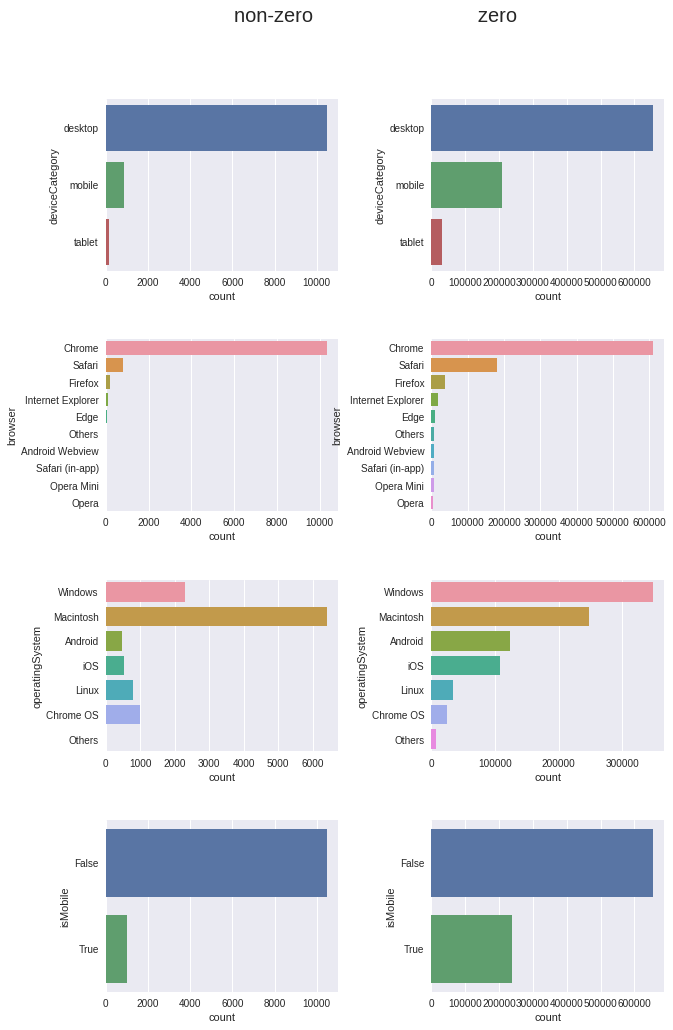

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)
sns.plt.suptitle('non-zero                              zero', fontsize=20)
sns.countplot(y='deviceCategory', data=train[train['Revenue'] == 'non-zero'],order=list(train['deviceCategory'].value_counts().index), ax = axes[0][0])
sns.countplot(y='deviceCategory', data=train[train['Revenue'] == 'zero'], order=list(train['deviceCategory'].value_counts().index), ax = axes[0][1])
sns.countplot(y='browser', data=train[train['Revenue'] == 'non-zero'], order=list(train['browser'].value_counts().index), ax = axes[1][0])
sns.countplot(y='browser', data=train[train['Revenue'] == 'zero'],order=list(train['browser'].value_counts().index), ax = axes[1][1])
sns.countplot(y='operatingSystem', data=train[train['Revenue'] == 'non-zero'], order=list(train['operatingSystem'].value_counts().index), ax = axes[2][0])
sns.countplot(y='operatingSystem', data=train[train['Revenue'] == 'zero'], order=list(train['operatingSystem'].value_counts().index), ax = axes[2][1])
sns.countplot(y='isMobile', data=train[train['Revenue'] == 'non-zero'], order=list(train['isMobile'].value_counts().index), ax = axes[3][0])
sns.countplot(y='isMobile', data=train[train['Revenue'] == 'zero'], order=list(train['isMobile'].value_counts().index),ax = axes[3][1])

- deviceCategoryはnon-zeroの方がデスクトップの割合高い   
- browserはzeroの方がSafariの割合高い   
- operatingSystemはnon-zeroがWindowsよりもMacintosh使用率高い
- non-zeroはChrome OSの使用率も高い
- non-zeroはモバイルOSの割合が低い

#### 地理情報

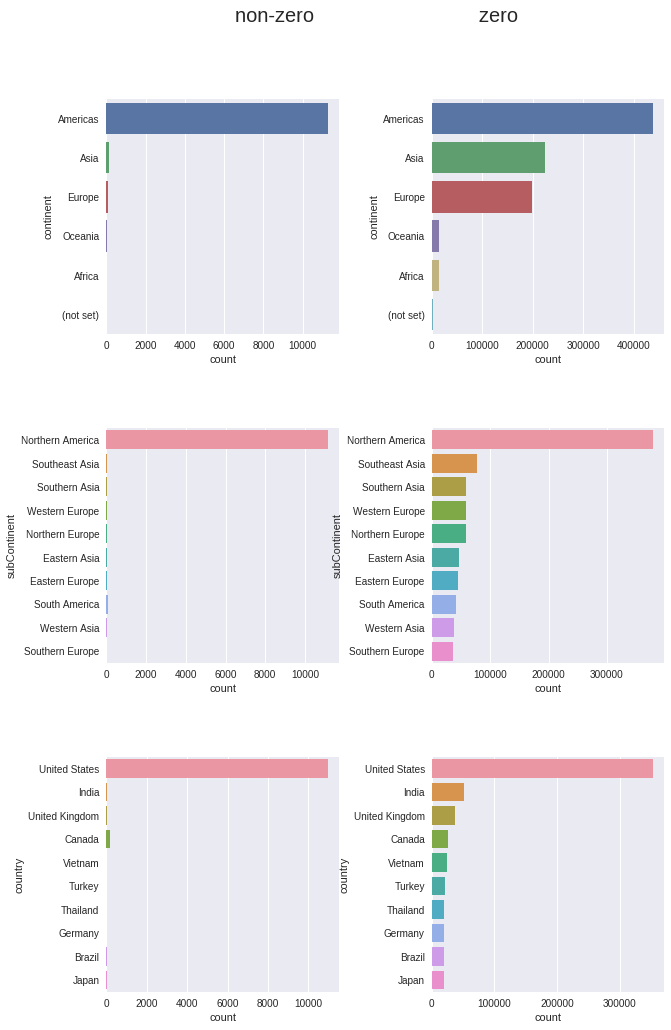

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)
sns.plt.suptitle('non-zero                              zero', fontsize=20)
sns.countplot(y='continent', data=train[train['Revenue'] == 'non-zero'],order=list(train['continent'].value_counts().index[0:6]), ax = axes[0][0])
sns.countplot(y='continent', data=train[train['Revenue'] == 'zero'], order=list(train['continent'].value_counts().index[0:6]), ax = axes[0][1])
sns.countplot(y='subContinent', data=train[train['Revenue'] == 'non-zero'], order=list(train['subContinent'].value_counts().index[0:10]), ax = axes[1][0])
sns.countplot(y='subContinent', data=train[train['Revenue'] == 'zero'],order=list(train['subContinent'].value_counts().index[0:10]), ax = axes[1][1])
sns.countplot(y='country', data=train[train['Revenue'] == 'non-zero'], order=list(train['country'].value_counts().index[0:10]), ax = axes[2][0])
sns.countplot(y='country', data=train[train['Revenue'] == 'zero'], order=list(train['country'].value_counts().index[0:10]), ax = axes[2][1])

non-zeroは圧倒的にアメリカ大陸が多い。   
お金を支払わず、閲覧だけ来る人がアジアとヨーロッパ多い。   
アメリカ大陸の中でも、北アメリカが圧倒的にお金を使っている。   
インドやイギリスが閲覧だけする人多い。


#### TrafficSource情報

In [29]:
  train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'browser', 'deviceCategory', 'isMobile',
       'operatingSystem', 'city', 'continent', 'country', 'metro',
       'networkDomain', 'region', 'subContinent', 'hits', 'pageviews',
       'transactionRevenue', 'campaign', 'medium', 'source', 'Revenue'],
      dtype='object')

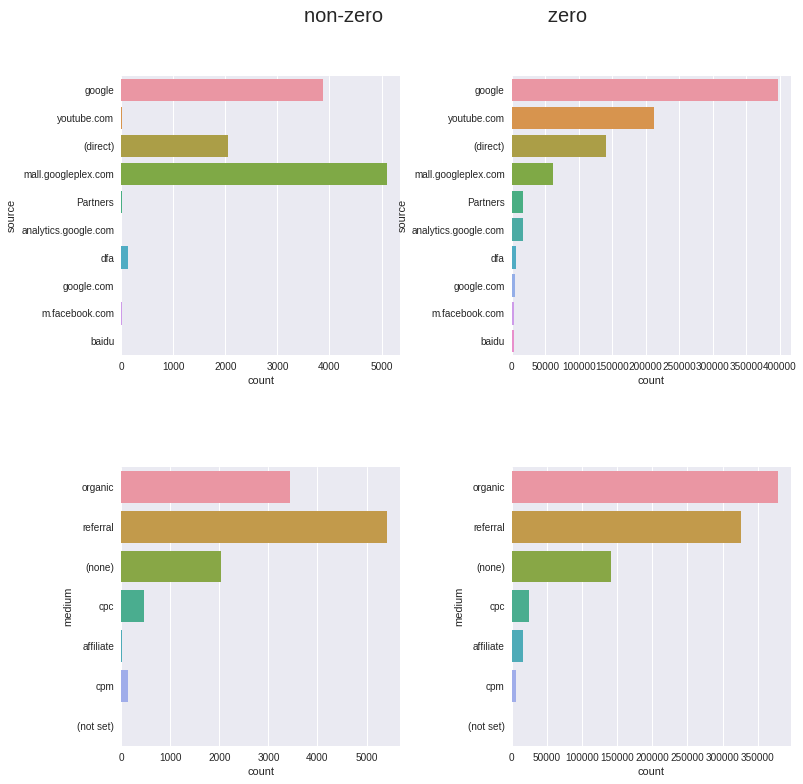

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)
sns.plt.suptitle('non-zero                              zero', fontsize=20)
sns.countplot(y='source', data=train[train['Revenue'] == 'non-zero'],order=list(train['source'].value_counts().index[0:10]), ax = axes[0][0])
sns.countplot(y='source', data=train[train['Revenue'] == 'zero'], order=list(train['source'].value_counts().index[0:10]), ax = axes[0][1])
sns.countplot(y='medium', data=train[train['Revenue'] == 'non-zero'],order=list(train['medium'].value_counts().index[0:10]), ax = axes[1][0])
sns.countplot(y='medium', data=train[train['Revenue'] == 'zero'], order=list(train['medium'].value_counts().index[0:10]), ax = axes[1][1])

Youtubeからのほとんどがお金を使っていない。Youtubeの全体数は多い。  
googleprexのお金を使う率は高い。  
organicよりもreferralのほうがお金使う人多い 。



#### 閲覧情報

In [0]:
#欠損値を0で埋める
train["pageviews"] = train["pageviews"].fillna(0).astype(int)
test["pageviews"] = test["pageviews"].fillna(0).astype(int)

(array([7.313e+03, 3.160e+03, 6.920e+02, 2.040e+02, 7.400e+01, 3.000e+01,
        1.500e+01, 4.000e+00, 5.000e+00, 4.000e+00, 2.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00, 6.000e+00]),
 array([  2. ,  35.2,  68.4, 101.6, 134.8, 168. , 201.2, 234.4, 267.6,
        300.8, 334. , 367.2, 400.4, 433.6, 466.8, 500. ]),
 <a list of 15 Patch objects>)

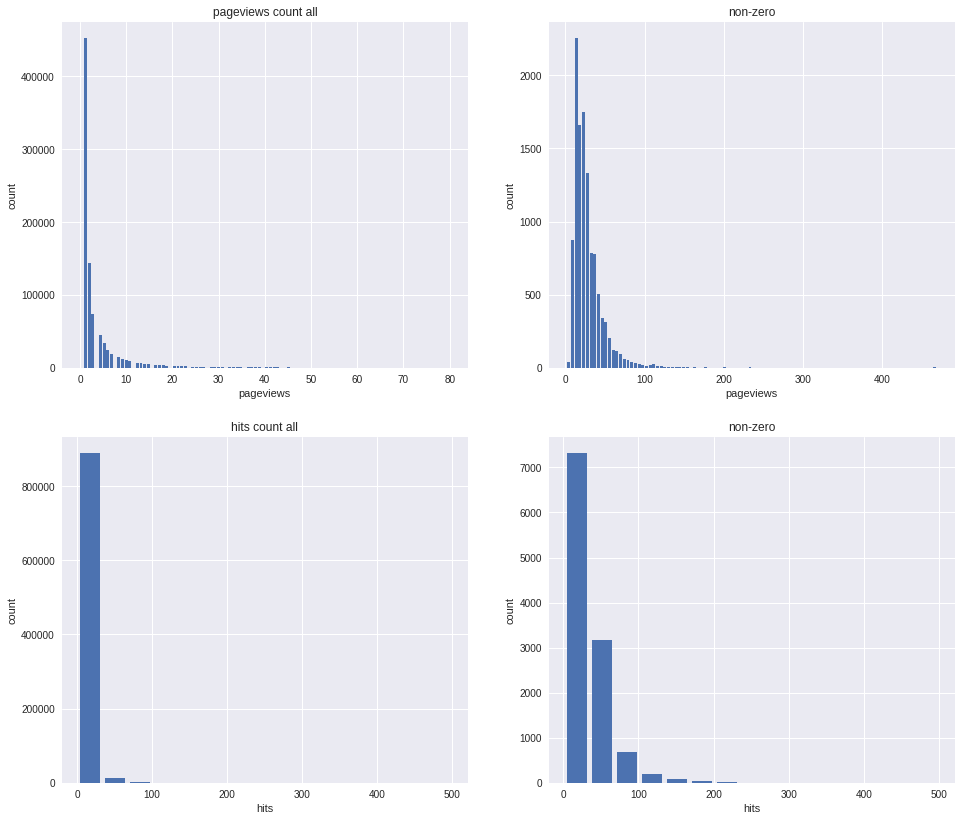

In [32]:
plt.figure(figsize=(16,14))
plt.subplot(2,2,1)
plt.title('pageviews count all')
plt.ylabel('count')
plt.xlabel('pageviews')
plt.hist(train["pageviews"], bins=100, range=(0,80),rwidth=0.8)

plt.subplot(2,2,2)
plt.title("non-zero")
plt.ylabel('count')
plt.xlabel('pageviews')
plt.hist(train[train['Revenue'] == 'non-zero']["pageviews"], bins=100, rwidth=0.8)

plt.subplot(2,2,3)
plt.title('hits count all')
plt.ylabel('count')
plt.xlabel('hits')
plt.hist(train["hits"], bins=15 ,rwidth=0.8)

plt.subplot(2,2,4)
plt.title("non-zero")
plt.ylabel('count')
plt.xlabel('hits')
plt.hist(train[train['Revenue'] == 'non-zero']["hits"], bins=15, rwidth=0.8)

pageviewもhitも多いほうが、よくお金が使われる。

## 型変換
データをfloat型に変換


In [0]:
#変数を型変換したデータセット用
tran = train.copy()
tesn = test.copy()

In [0]:
#文字列の説明変数を数値に変換

str_cols = ["channelGrouping","browser", "deviceCategory", "isMobile", "operatingSystem", "city",
       "continent", "country", "metro", "networkDomain", "region", "subContinent", "campaign",
       "medium", "source"]
for col in str_cols:
    le = preprocessing.LabelEncoder()
    le.fit(list(tran[col].values.astype('str')) + list(tesn[col].values.astype('str')))
    tran[col] = le.transform(list(tran[col].values.astype('str'))).astype(float)
    tesn[col] = le.transform(list(tesn[col].values.astype('str'))).astype(float)

#データの方をfloatに変換
num_cols = ["hits", "pageviews", "visitNumber", "visitStartTime"]

for col in num_cols:
  tran[col] = tran[col].astype(float)
  tesn[col] = tesn[col].astype(float)

## データセット作成
学習の入力値を作成

In [0]:
train_y = np.log1p(train["transactionRevenue"].values)
train_id = train["fullVisitorId"].values
test_id = test["fullVisitorId"].values

In [0]:
use_data = ["channelGrouping","browser", "deviceCategory",  "operatingSystem",
       "continent", "country", "networkDomain", "region", "subContinent", "campaign",
       "pageviews", "visitNumber", "visitStartTime"]

In [0]:
#標準化
tran[use_data] =  (tran[use_data] - tran[use_data].mean()) / tran[use_data].std(ddof=1)
tesn[use_data] =  (tesn[use_data] - tesn[use_data].mean()) / tesn[use_data].std(ddof=1)

In [0]:
dev = tran[tran['date']<=datetime.date(2017,5,31)]
val = tran[tran['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev['transactionRevenue'].values.astype(int))
val_y = np.log1p(val['transactionRevenue'].values)

dev_x = dev[use_data].values   #学習データの入力
val_x = val[use_data].values   #評価データの入力
test_x = tesn[use_data].values #テストデータの入力

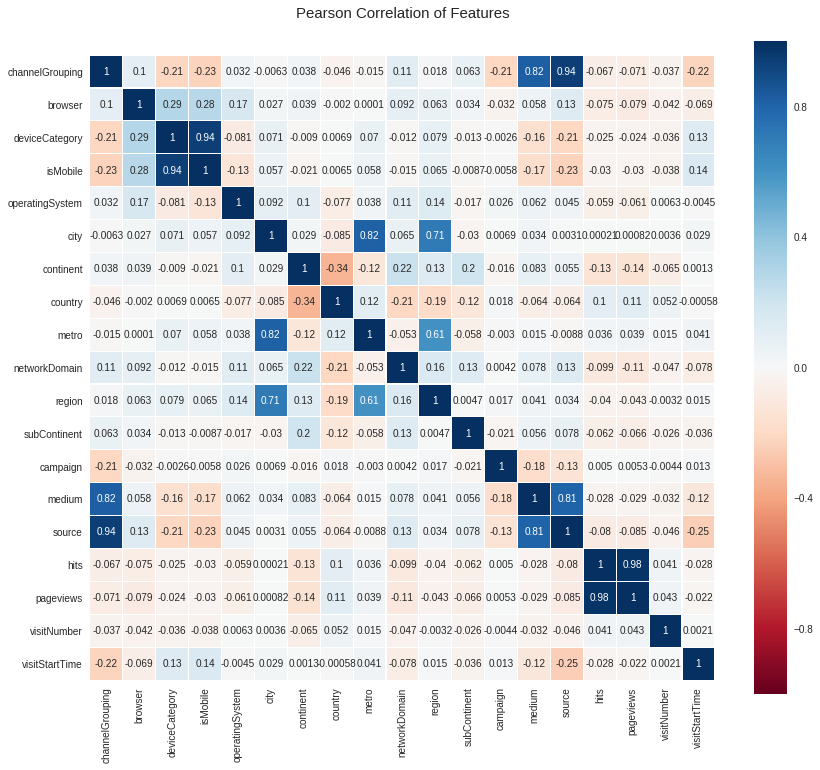

In [57]:
#説明変数の相関
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(tran[use_data].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# モデル構築

In [0]:
def model_helper(model):
  model.fit(dev_x, dev_y.astype(int))
  val_pred = model.predict(val_x)
  test_pred = model.predict(test_x)
  rmse = np.sqrt(mean_squared_error(val_pred, val_y))
  
  importances = model.feature_importances_
  indices = np.argsort(importances)

  plt.figure(figsize=(6,6))
  plt.barh(range(len(indices)), importances[indices], color='b', align='center')
  plt.yticks(range(len(indices)), tran[use_data].columns[indices])
  plt.show()
  
  return {'val_pred':val_pred, 'test_pred':test_pred, 'rmse':rmse}

## ランダムフォレスト

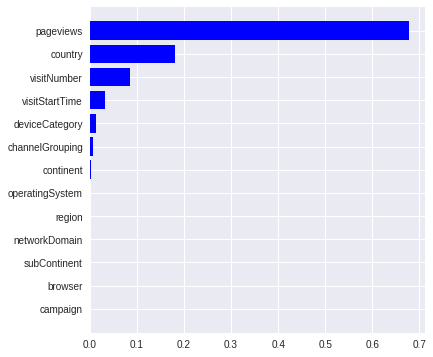

1.7688264530200974

In [102]:
from sklearn.ensemble import RandomForestRegressor 

random_reg = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=5, criterion='mse')
random_result = model_helper(random_reg)
random_result['rmse']

In [0]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
random_result["test_pred"][random_result["test_pred"]<0] = 0
sub_df["PredictedLogRevenue"] = random_result["test_pred"]
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("standard_random_forest.csv", index=False)

In [0]:
parameters = {
        'n_estimators'      : [5, 10, 30, 50, 100, 200],
        'random_state'      : [0],
        'min_samples_split' : [0.2, 0.4, 0.6, 0.8, 0.9],
        'max_depth'         : [3, 5, 10, 15, 20, 25],
}

reg = GridSearchCV(RandomForestRegressor(), parameters, verbose=1,cv=4)
reg = reg.fit(tran[use_data], train_y)

reg.best_estimator_

Fitting 4 folds for each of 180 candidates, totalling 720 fits


## XGBoost

In [0]:
from xgboost.sklearn import XGBRegressor


parameters = {"learning_rate":[0.1,0.3,0.5],
             "max_depth": [2,3,5,10],
             'n_estimators': [50,100,200],
             "subsample":[0.5,0.8,0.9,1],
             "colsample_bytree": [0.5,1.0],
              }

reg = GridSearchCV(XGBRegressor(), parameters, verbose=1,cv=4)
reg = reg.fit(tran[use_data], train_y)

reg.best_estimator_

# kaggleアップロード

In [105]:
!kaggle competitions submit -c ga-customer-revenue-prediction -f standard_random_forest.csv -m "standard_random_forest"

Successfully submitted to Google Analytics Customer Revenue Prediction

# データ保存 to Drive

In [20]:
import pickle

f = open('/content/gdrive/My Drive/kaggle/Google_Analytics_Customer_Revenue_Prediction/train.binaryfile','wb')
pickle.dump(train,f)
f.close
sleep(3)
f = open('/content/gdrive/My Drive/kaggle/Google_Analytics_Customer_Revenue_Prediction/test.binaryfile','wb')
pickle.dump(test,f)
f.close
sleep(3)
f = open('/content/gdrive/My Drive/kaggle/Google_Analytics_Customer_Revenue_Prediction/tran.binaryfile','wb')
pickle.dump(tran,f)
f.close
sleep(3)
f = open('/content/gdrive/My Drive/kaggle/Google_Analytics_Customer_Revenue_Prediction/tesn.binaryfile','wb')
pickle.dump(tesn,f)
f.close


<function BufferedWriter.close>

# データダウンロード from Drive


In [0]:
import pickle
 
f = open('/content/gdrive/My Drive/kaggle/Google_Analytics_Customer_Revenue_Prediction/train.binaryfile','rb')
train = pickle.load(f)
f.close()

f = open('/content/gdrive/My Drive/kaggle/Google_Analytics_Customer_Revenue_Prediction/test.binaryfile','rb')
test = pickle.load(f)
f.close()

f = open('/content/gdrive/My Drive/kaggle/Google_Analytics_Customer_Revenue_Prediction/tran.binaryfile','rb')
tran = pickle.load(f)
f.close()

f = open('/content/gdrive/My Drive/kaggle/Google_Analytics_Customer_Revenue_Prediction/tesn.binaryfile','rb')
tesn = pickle.load(f)
f.close()

In [29]:
while 1:
  sleep(10)

KeyboardInterrupt: ignored